## 5.12　专题：高斯混合模型
在实际应用中，k-means 的非概率性和它仅根据到簇中心点的距离来指派簇的特点将导致性能低下。

这一节将介绍高斯混合模型，该模型可以被看作是k-means思想的一个扩展，但它也是一种非常强大的聚类评估工具。还是从标准导入开始：

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### 5.12.1　高斯混合模型（GMM）为什么会出现：k-means算法的缺陷

下面来介绍一些k-means 算法的不足之处，并思考如何改进我们的聚类模型。就像前一节所看到的，只要给定简单且分离性非常好的数据，k-means 就可以找到合适的聚类结果。

例如，只要有简单的数据簇，k-means 算法就可以快速给这些簇作标记，标记结果和通过肉眼观察到的簇的结果十分接近（如图5-124 所示）：

In [2]:
# 生成数据
from sklearn.datasets.samples_generator import make_blobs

X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # 交换列是为了方便画图

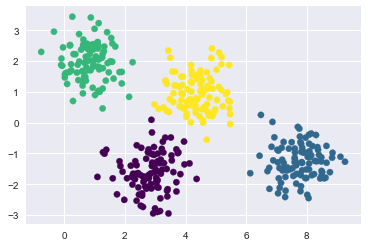

In [3]:
#用k-means标签画出数据
from sklearn.cluster import KMeans

kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

通过直接观察可以发现，某些点的归属簇比其他点的归属簇更加明确。例如，中间的两个簇似乎有一小块区域重合，因此我们对重合部分的点将被分配到哪个簇不是很有信心。不幸的是，**k-means 模型本身也没有度量簇的分配概率或不确定性的方法（虽然可以用数据重抽样方法bootstrap 来估计不确定性）**。因此，我们必须找到一个更通用的模型。

理解k-means 模型的一种方法是，它在每个簇的中心放置了一个圆圈（在更高维空间中是一个超空间），圆圈半径根据最远的点与簇中心点的距离算出。这个半径作为训练集分配簇的硬切断（hard cutoff），即在这个圆圈之外的任何点都不是该簇的成员。可以用以下函数将这个聚类模型可视化（如图5-125 所示）：

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    # 画出输入数据
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    
    # 画出k-means模型的表示
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

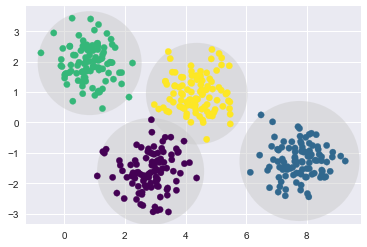

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

k-means 有一个重要特征，它要求这些簇的模型必须是圆形：**k-means 算法没有内置的方法来实现椭圆形的簇**。因此，如果对同样的数据进行一些转换，簇的分配就会变得混乱（如图5-126 所示）：

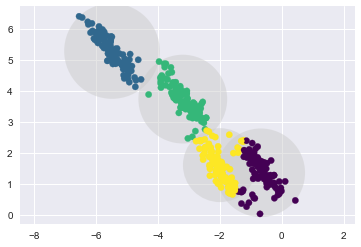

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

通过肉眼观察，可以发现这些变形的簇并不是圆形的，因此圆形的簇拟合效果非常糟糕。总之，k-means 对这个问题有点无能为力，只能强行将数据拟合至4 个圆形的簇，但却导致多个圆形的簇混在一起、相互重叠，右下部分尤其明显。有人可能会想用PCA（详情请参见5.9 节）先预处理数据，从而解决这个特殊的问题。但实际上，**PCA 也不能保证这样的全局操作不会导致单个数据被圆形化**。

**k-means 的这两个缺点——类的形状缺少灵活性、缺少簇分配的概率——使得它对许多数据集（特别是低维数据集）的拟合效果不尽如人意。**

你可能想通过对k-means 模型进行一般化处理来弥补这些不足，例如可以通过比较每个点与所有簇中心点的距离来度量簇分配的不确定性，而不仅仅是关注最近的簇。你也可能想通过将簇的边界由圆形放宽至椭圆形，从而得到非圆形的簇。实际上，这正是另一种的聚类模型——高斯混合模型——的两个基本组成部分。

### 5.12.2　一般化E-M：高斯混合模型
一个高斯混合模型（Gaussian mixture model，GMM）试图找到多维高斯概率分布的混合体，从而获得任意数据集最好的模型。在最简单的场景中，GMM 可以用与k-means 相同的方式寻找类（如图5-127 所示）：

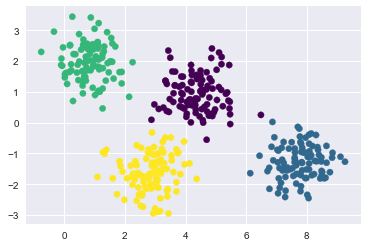

In [8]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

但由于GMM 有一个隐含的概率模型，因此它也可能找到簇分配的概率结果——在Scikit-Learn 中用predict_proba 方法实现。这个方法返回一个大小为[n_samples, n_clusters]的矩阵，矩阵会给出任意点属于某个簇的概率：

In [9]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.531 0.469 0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]]


我们可以将这个不确定性可视化，用每个点的大小体现预测的不确定性，使其成正比。由图5-128 可知，在簇边界上的点反映了簇分配的不确定性：

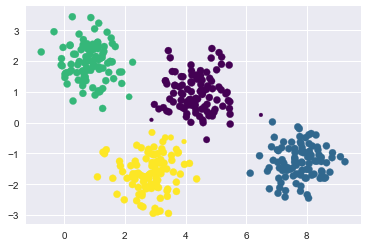

In [10]:
size = 50 * probs.max(1) ** 2 # 平方强调差异
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

高斯混合模型本质上和k-means 模型非常类似，它们都使用了期望最大化方法，具体实现如下。
1. 选择初始簇的中心位置和形状。
2. 重复直至收敛。
    1. 期望步骤（E-step）：为每个点找到对应每个簇的概率作为权重。
    2. 最大化步骤（M-step）：更新每个簇的位置，将其标准化，并且基于所有数据点的权重来确定形状。

最终结果表明，**每个簇的结果并不与硬边缘的空间（hard-edged sphere）有关，而是通过高斯平滑模型实现**。正如在k-means 中的期望最大化方法，这个算法有时并不是全局最优解，因此在实际应用需要使用多个随机初始解。

下面创建一个可视化GMM 簇位置和形状的函数，该函数用gmm 的输出结果画出椭圆：

In [14]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """用给定的位置和协方差画一个椭圆"""
    ax = ax or plt.gca()
    
    # 将协方差转换成主轴
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # 画出椭圆
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
        ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

经过上述处理之后，再给GMM 四个成分处理初始数据，看看会得到什么结果（如图5-129 所示）：

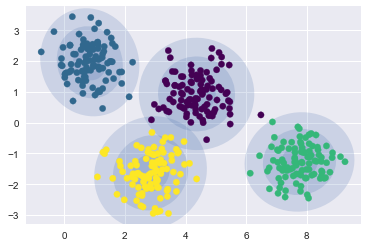

In [15]:
gmm = GaussianMixture (n_components=4, random_state=42)
plot_gmm(gmm, X)

同理，也可以用GMM 方法来拟合扩展过的数据集。高斯模型允许使用全协方差（full covariance），即使是于非常扁平的椭圆形的簇，该模型也可以处理（如图5-130 所示）：

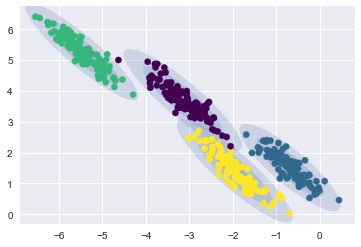

In [17]:
gmm = GaussianMixture (n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

从图中可以明显看出，GMM 突破了前面k-means 算法的两个局限性。

**选择协方差的类型**
<br>如果仔细观察前面的拟合结果，你会发现每个拟合的covariance_type 选项的设置是不同的。这个超参数控制了每个簇的形状自由度，其设置对任何问题都非常重要。它的默认设置是covariance_type="diag"，意思是簇在每个维度的尺寸都可以单独设置，椭圆边界的主轴与坐标轴平行。另一个更简单、更快的模型是covariance_type="spherical"，该模型通过约束簇的形状，让所有维度相等。这样得到的聚类结果和k-means 聚类的特征是相似的，虽然两者并不完全相同。还有一个更复杂、计算复杂度也更高的模型（特别适应于高维度数据）是covariance_type="full"，该模型允许每个簇在任意方向上用椭圆建模。

可以用这三种方法可视化同一个聚类数据，如图5-131 所示：
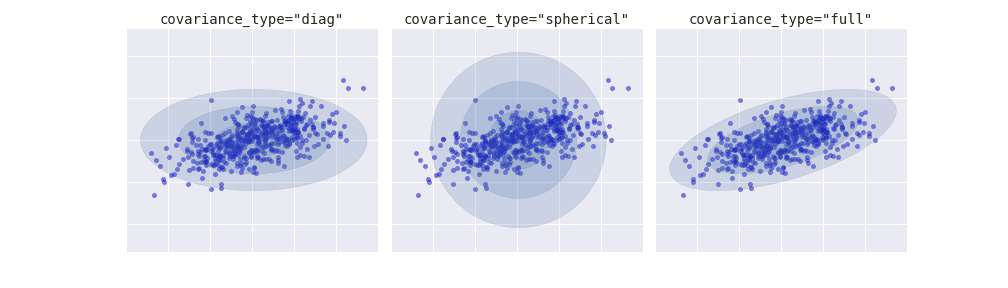

### 5.12.3　将GMM用作密度估计
虽然GMM 通常被归类为聚类算法，但它本质上是一个密度估计算法；也就是说，从技术的角度考虑，一个GMM 拟合的结果并不是一个聚类模型，而是描述数据分布的生成概率模型。
<br>例如从Scikit-Learn 的make_moons 函数生成的一些数据（可视化结果如图5-132 所示），这些数据在5.11 节介绍过：

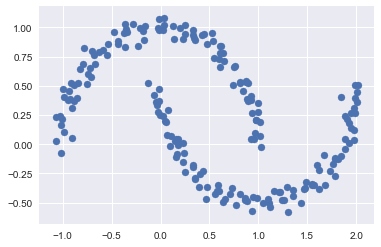

In [18]:
from sklearn.datasets import make_moons

Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

如果用GMM 对数据拟合出两个成分，那么作为一个聚类模型的结果，其实没什么用（如图5-133 所示）：

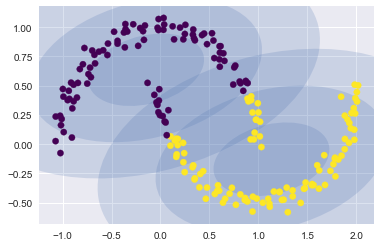

In [20]:
gmm2 = GaussianMixture (n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

但如果选用更多的成分而忽视簇标签，就可以找到一个更接近输入数据的拟合结果（如图5-134 所示）：

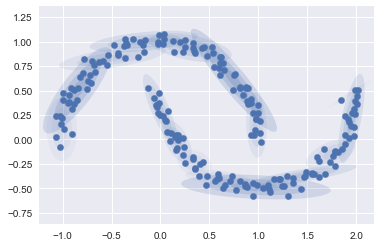

In [22]:
gmm16 = GaussianMixture (n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

这里采用16 个高斯曲线的混合形式不是为了找到数据的分隔的簇，而是为了对输入数据的总体分布建模。这就是分布函数的生成模型——GMM 可以为我们生成新的、与输入数据类似的随机分布函数。例如，下面是用GMM 拟合原始数据获得的16 个成分生成的400个新数据点（如图5-135 所示）：

In [45]:
# Xnew = gmm16.sample(400, random_state=42)
Xnew = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

<function tuple.index>

GMM 是一种非常方便的建模方法，可以为数据估计出任意维度的随机分布。

需要多少成分？
作为一种生成模型，GMM 提供了一种确定数据集最优成分数量的方法。由于生成模型本身就是数据集的概率分布，因此可以利用该模型来评估数据的似然估计，并利用交叉检验防止过拟合。还有一些纠正过拟合的标准分析方法，例如用赤池信息量准则（Akaike information criterion，AIC，https://en.wikipedia.org/wiki/Akaike_information_criterion ）、贝叶斯信息准则（Bayesian information criterion，BIC，https://en.wikipedia.org/wiki/Bayesian_information_criterion ）调整模型的似然估计。Scikit-Learn 的GMM 评估器已经内置了以上两种度量准则的计算方法，在GMM 方法中使用它们很方便。

下面用AIC 和BIC 分别作为月球数据集的GMM 成分数量的函数（如图5-136 所示）：

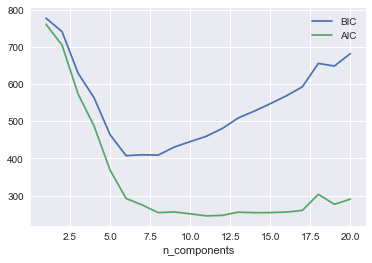

In [25]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

**类的最优数量出现在AIC 或BIC 曲线最小值的位置，最终结果取决于我们更希望使用哪一种近似**。AIC 告诉我们，选择16 个成分可能太多，8 个~12 个成分可能是更好的选择。由于这类经典问题的存在，BIC 推荐了一个更简单的模型。

这里需要注意的是：**成分数量的选择度量的是GMM 作为一个密度评估器的性能，而不是作为一个聚类算法的性能**。建议你还是把GMM 当成一个密度评估器，仅在简单数据集中才将它作为聚类算法使用。

### 5.12.4　示例：用GMM生成新的数据
前面介绍了一个将GMM 作为数据生成模型的示例，目的是根据输入数据的分布创建一个新的样本集。这次还利用这个思路，为前面使用过的标准手写数字库生成新的手写数字。首先，用Scikit-Learn 的数据工具导入手写数字数据：

In [54]:
from sklearn.datasets import load_digits

digits = load_digits()
digits.data.shape

(1797, 64)

然后，画出前100 个数据，看看这些数据（如图5-137 所示）：

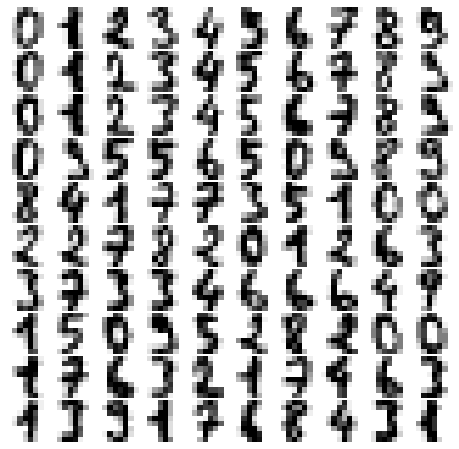

In [46]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
    subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)

plot_digits(digits.data)

现在有大约1800 个64 维度的数字，可以创建一个GMM 模型来生成更多的数字。GMM在这样一个高维空间中可能不太容易收敛，因此先使用一个不可逆的降维算法。我们在这里直接用PCA，让PCA 算法保留投影后样本数据99% 的方差：

In [55]:
from sklearn.decomposition import PCA

pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

结果降到了41 维，削减了接近1/3 的维度的同时，几乎没有信息损失。再对这个投影数据使用AIC，从而得到GMM 成分数量的粗略估计（如图5-138 所示）：

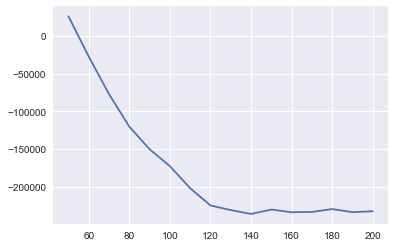

In [56]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0) 
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]

plt.plot(n_components, aics);

在大约110 个成分的时候，AIC 是最小的，因此我们打算使用这个模型——立刻用它拟合数据，并且确认它已经收敛：

In [57]:
gmm = GaussianMixture(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


现在就可以在41 维投影空间中画出这100 个点的示例，将GMM 作为生成模型：

In [61]:
data_new = gmm.sample(100)
data_new.shape()

AttributeError: 'tuple' object has no attribute 'shape'

最后，可以通过PCA 对象逆变换来构建新的数字（如图5-139 所示）：

In [ ]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

从图中可以看出，大部分数字与原始数据集的数字别无二致。

简单回顾上述操作步骤：首先获得手写数字的示例数据，然后构建该数据的分布模型，最后依据分布模型生成一批新的示例数字。这些“手写数字”并不会单独出现在原始数据集中，而是获取混合模型输入数据的一般特征。这个数字生成模型同时也可以证明，生成模型是贝叶斯生成分类器的一个非常有用的成分，就像下一节将要介绍内容的一样。